### Libraries, functions etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import expit

import sys
sys.path.insert(1, '../')

import measures
from model import LogReg
from preprocessing import Preprocessor
import experiments

### Loading data

In [3]:
wdbc_df=pd.read_csv('../data/wdbc.csv')

y_wdbc=wdbc_df['diagnosis']=="M"
X_wdbc=wdbc_df.drop(columns=["id","diagnosis","Unnamed: 32"])

prep_wdbc = Preprocessor()

In [4]:
X_wdbc_train, X_wdbc_test, y_wdbc_train, y_wdbc_test = prep_wdbc.train_test_split(X_wdbc, y_wdbc)

In [5]:
remove_coll,balance_classes,scaling=True,True,False
X_train=X_wdbc_train.copy()
X_test=X_wdbc_test.copy()
y_train=y_wdbc_train.copy()
y_test=y_wdbc_test.copy()
if remove_coll:
    X_train = prep_wdbc.remove_multicollinearity_fit_transform(X_train)
    X_test = prep_wdbc.remove_multicollinearity_transform(X_test)
if balance_classes:
    X_train,y_train=prep_wdbc.class_balancing(X_train,y_train)
if scaling:
    s = StandardScaler()
    X_train = s.fit_transform(X_train)
    X_test = s.transform(X_test)
#próbowałem to wrzucić do funkcji preprocess_data, ale coś wywala błąd więc na razie odpuszczam    
    
#One Hot Encoding
#X_train = prep_wdbc.one_hot_encoding_fit_transform(X_train)
#X_test = prep_wdbc.one_hot_encoding_transform(X_test)

X_train=X_train.to_numpy()
y_train=y_train.to_numpy()
X_test=X_test.to_numpy()
y_test=y_test.to_numpy()

7 numerical features left in dataset  0  categorical
Training dataset has now  534 obervations. 50.0  percent is in positive group.


#### 1. Convergence analysis: check how the value of log-likelihood function depends on the number of iterations for 4 above algorithms.

In [9]:
lr=0.01
n_epochs=1000

lr_models = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=0.1),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=0.01, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

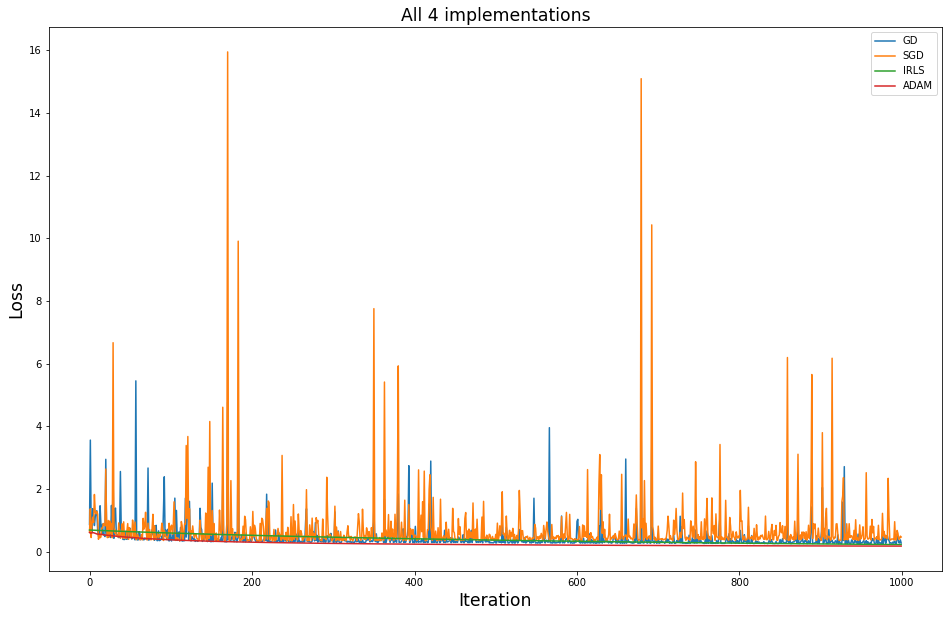

In [10]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models.items():
    model.train(X_train, y_train)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.show()

#### 2. Check how the value of learning rate and other parameters affect the results.

In [23]:
tested_l_rates=np.linspace(start=0.2,stop=1e-5,num=11)
tested_algorithms={'GD': 'Gradient Descent','SGD':'Stochastic Gradient Descent','ADAM':'Adaptive Moment Estimation'}

res_test_learning_rates=experiments.test_learning_rates(X_train=X_train,
                                                        y_train=y_train,
                                                        X_test=X_test,
                                                        y_test=y_test,
                                                        l_rates=tested_l_rates,
                                                        algorithms=tested_algorithms)

res_test_learning_rates.sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False)

,learning_rate,method,accuracy,recall,precision,F_measure
13,0.120004,SGD,0.902,0.811,0.915,0.860
2,0.200000,ADAM,0.902,0.792,0.933,0.857
5,0.180001,ADAM,0.902,0.792,0.933,0.857
8,0.160002,ADAM,0.902,0.792,0.933,0.857
11,0.140003,ADAM,0.895,0.792,0.913,0.848
14,0.120004,ADAM,0.895,0.792,0.913,0.848
17,0.100005,ADAM,0.895,0.792,0.913,0.848
7,0.160002,SGD,0.888,0.830,0.863,0.846
1,0.200000,SGD,0.881,0.811,0.860,0.835
4,0.180001,SGD,0.881,0.811,0.860,0.835


From the informations above (tested for n_epochs=100,175 and 250) we conclude that the best learning rates are:
- 0.2 for ADAM (its lr decreases a little with each epoch)
- 0.12 for SGD
- 0.02 or 0.04 for GD (batch size=0.1*size(dataset))

In [28]:
tested_betas_1=np.linspace(start=0.75,stop=.97,num=12)
tested_betas_2=np.linspace(start=0.90,stop=0.99,num=10)

res_test_betas=experiments.test_betas(X_train=X_train, 
                                      y_train=y_train,
                                      X_test=X_test,
                                      y_test=y_test,
                                      tested_betas1=tested_betas_1,
                                      tested_betas2=tested_betas_2,lr=0.2,n_epochs=30)

res_test_betas.sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False).head(10)

,beta1,beta2,accuracy,recall,precision,F_measure
30,0.81,0.90,0.881119,0.773585,0.891304,0.828283
86,0.91,0.96,0.881119,0.773585,0.891304,0.828283
87,0.91,0.97,0.881119,0.754717,0.909091,0.824742
88,0.91,0.98,0.881119,0.754717,0.909091,0.824742
89,0.91,0.99,0.881119,0.754717,0.909091,0.824742
31,0.81,0.91,0.874126,0.773585,0.872340,0.820000
32,0.81,0.92,0.874126,0.773585,0.872340,0.820000
33,0.81,0.93,0.874126,0.773585,0.872340,0.820000
41,0.83,0.91,0.874126,0.773585,0.872340,0.820000
85,0.91,0.95,0.874126,0.773585,0.872340,0.820000


The experiments (tested n_epochs=30, 40, 50, 75 ,100) above show that beta1 and beta2 paramenters don't have a big incluence on the models performance. However always beta_1=0.91 was among the best results

#### 3. Compare the classification performance of logistic regression (try all 4 methods: IWLS, GD, SGD and ADAM) and 3 popular classification methods: LDA, QDA and KNN. Use the performance measures implemented in Part 2 and datasets prepared in Part 1. The performance measures should be calculated on test set. If the given algorithm does not converge, within 1000 iterations, stop the algorithm and use the solutions from the last iteration.

We'll use learning rates and other parameters which perfomed the best in the previous experiments

In [29]:
n_epochs=1000

batch_size_gd=0.1
lr_gd=0.02

lr_sgd=0.12

lr_adam=0.2
beta1_adam=0.91
beta2_adam=0.95

models = {
    'GD': LogReg(optimization='Gradient Descent',
                 learning_rate=lr_gd,
                 epochs=n_epochs,
                 batch_size=batch_size_gd),
    'SGD': LogReg(optimization='Stochastic Gradient Descent',
                  learning_rate=lr_sgd,
                  epochs=n_epochs),
    'IRLS': LogReg(optimization='Iterative Reweighted Least Squares',
                   epochs=n_epochs),
    'ADAM': LogReg(optimization='Adaptive Moment Estimation',
                   epochs=n_epochs,
                   learning_rate=lr_adam,
                   beta_1=beta1_adam,
                   beta_2=beta2_adam,
                   epsilon=1e-8),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'LR': LogisticRegression(max_iter=n_epochs),
    'kNN': KNeighborsClassifier()
}

In [30]:
res_final=experiments.final_comparisson(X_train=X_train,
                                        y_train=y_train,
                                        X_test=X_test,
                                        y_test=y_test,
                                        models=models)

res_final.sort_values(by=['accuracy','f_measure','recall','precision'],ascending=False)

,model,accuracy,recall,precision,f_measure
5,QDA,0.951049,0.924528,0.942308,0.933333
2,IRLS,0.944056,0.905660,0.941176,0.923077
3,ADAM,0.930070,0.849057,0.957447,0.900000
4,LDA,0.930070,0.849057,0.957447,0.900000
1,SGD,0.909091,0.811321,0.934783,0.868687
0,GD,0.902098,0.792453,0.933333,0.857143
6,LR,0.895105,0.811321,0.895833,0.851485
7,kNN,0.832168,0.792453,0.763636,0.777778


As we can see for this dataset our results match expected ones. IRLS perfomed the best, followed by ADAM, SGD and GD whereas GD and SGD perfomances were very similar. Some of the other methods such as QDA and LDA were one of the best when LR especially kNN perfomed pretty poorly.

#### 5. Comparing convergence analysis for the "best" parameters.

In [32]:
n_epochs=1000

batch_size_gd=0.1
lr_gd=0.02

lr_sgd=0.12

lr_adam=0.2
beta1_adam=0.91
beta2_adam=0.95

lr_models = {
     'GD': LogReg(optimization='Gradient Descent',
                 learning_rate=lr_gd,
                 epochs=n_epochs,
                 batch_size=batch_size_gd),
    'SGD': LogReg(optimization='Stochastic Gradient Descent',
                  learning_rate=lr_sgd,
                  epochs=n_epochs),
    'IRLS': LogReg(optimization='Iterative Reweighted Least Squares',
                   epochs=n_epochs),
    'ADAM': LogReg(optimization='Adaptive Moment Estimation',
                   epochs=n_epochs,
                   learning_rate=lr_adam,
                   beta_1=beta1_adam,
                   beta_2=beta2_adam,
                   epsilon=1e-8)
 }

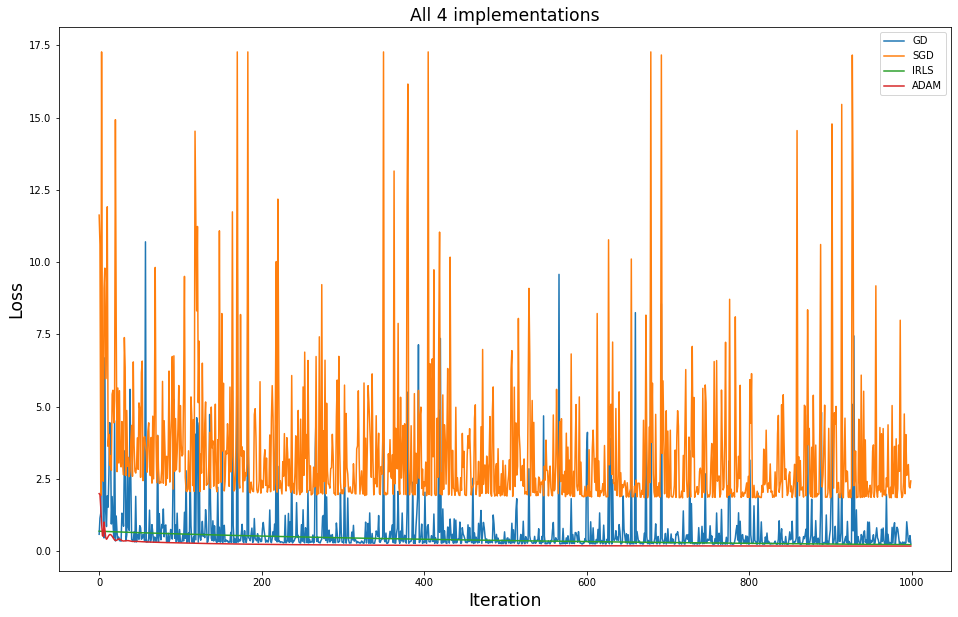

In [33]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models.items():
    model.train(X_train, y_train)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.show()